## Use Segment Anything(SAM) Model to Get the Eye Masks

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from sam_funcs import *

### Load the image

1. enter the catalog number e.g. UCSB-IZC00035539
2. choose hef or hal image e.g. hef


In [9]:
# input the catalog number and get the image
catalog_num = input("Enter the Catalog Number: \n")
folder_path = '../data/' + catalog_num
image_name = get_image_names(folder_path, keyword='hef')
image_path = folder_path + '/' + image_name
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

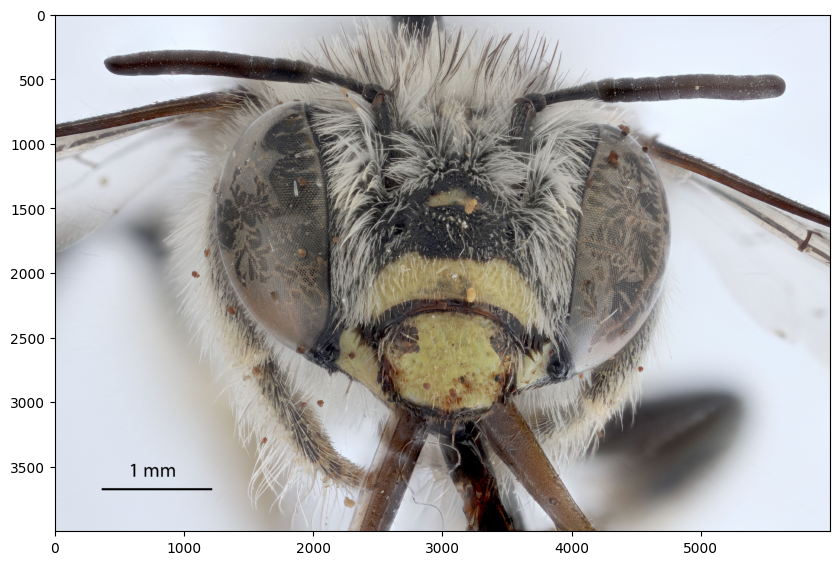

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

### Load the SAM model Checkpoint

In [10]:
# import the SAM checkpoint
#import sys
#sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [11]:
predictor.set_image(image)

## Specifying a specific object with a box and points

The first code chunk will pop out a window to help you select the positive/negative points and the box for segmentation.
1. The first two clicks are for the box.
2. Then we left click for the positive points and right click for the negative points.
3. The number of points can be specified by the user in `get_seed_points` function.




In [12]:
# define the prompt: box and points(positive and negative)
input_box = crop_box(image_path)
# specify how many points you want to use
input_point,input_label = get_seed_points(image_path, 8)

In [14]:
# make the inference via SAM
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

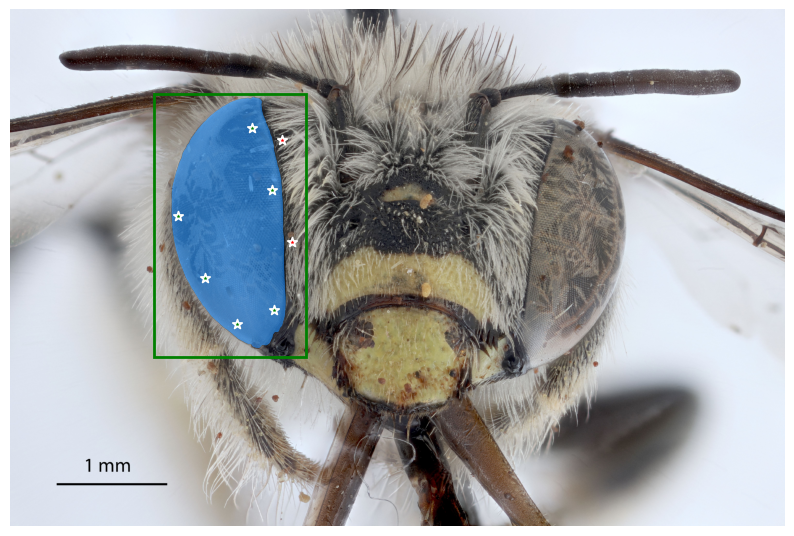

In [15]:
# visualize the mask and prompts in the original image
# try different prompts if the mask is not good
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca(), marker_size=50)
plt.axis('off')
plt.show()

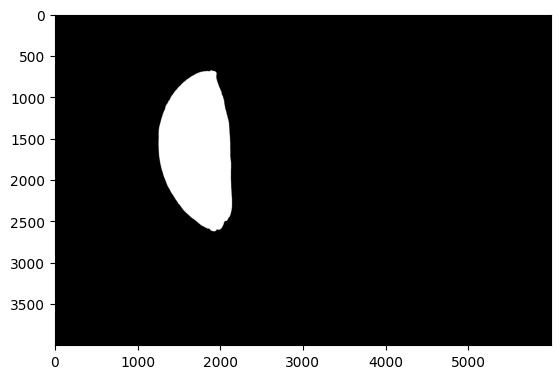

In [15]:
# check the mask in the binary image
eye_mask = masks.astype(np.uint8)
eye_mask = np.squeeze(eye_mask)
binary_mask_image = (eye_mask * 255).astype(np.uint8)
binary_mask_image = cv2.cvtColor(binary_mask_image, cv2.COLOR_BGR2RGB)

plt.imshow(binary_mask_image)
plt.axis('on')
plt.show()

### Save the mask for curvature analysis

In [11]:
# save the (left or right) eye mask to the data folder
which_eye = input("Which eye is this? (1 for left or 2 for right): ")
if which_eye == '1':
    mask_path = '../data/' + catalog_num + '/' + 'eye_mask_left.jpg'
elif which_eye == '2':
    mask_path = '../data/' + catalog_num + '/' + 'eye_mask_right.jpg'
else:
    print("Wrong input! Please enter 1 or 2.")

cv2.imwrite(mask_path, binary_mask_image)

True